# PatchTST & TFT Benchmark on Synthetic Data

This notebook fabricates a tiny OHLCV dataset, stages it through the `trading_transformers` pipeline, and trains two reference backbones:

1. The lightweight PatchTST reference implementation.
2. The simplified Temporal Fusion Transformer (TFT) backbone.

Both runs share the same feature engineering and `DataModule`.

In [1]:
import logging
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch
from trading_transformers.features import ContinuousFeatureBuilder, ContinuousFeatureConfig
from trading_transformers.logging import configure_logging
from trading_transformers.models import (
    PatchTSTReference,
    PatchTSTReferenceConfig,
    TemporalFusionTransformerBackbone,
    TemporalFusionTransformerConfig,
)
from trading_transformers.training.config import DataConfig
from trading_transformers.training.datamodule import DataModuleBuilder
from trading_transformers.training.lightning import ForecastingModule, OptimizerParams
configure_logging(level=logging.INFO)
pl.seed_everything(42)
torch.set_float32_matmul_precision('medium')
plt.rcParams.update({"figure.figsize": (8, 4)})
plt.rcParams['axes.grid'] = True


Seed set to 42


In [2]:
def fabricate_ohlcv(rows: int = 1_000) -> pd.DataFrame:
    rng = np.random.default_rng(2025)
    index = pd.date_range('2024-01-01', periods=rows, freq='min')
    price = 100 + rng.normal(0, 0.3, size=rows).cumsum()
    high = price + rng.uniform(0.05, 0.3, size=rows)
    low = price - rng.uniform(0.05, 0.3, size=rows)
    close = price + rng.uniform(-0.2, 0.2, size=rows)
    volume = rng.uniform(800, 1200, size=rows)
    return pd.DataFrame({
        'timestamp': index,
        'open': price,
        'high': high,
        'low': low,
        'close': close,
        'volume': volume,
    })

raw_frame = fabricate_ohlcv()
feature_builder = ContinuousFeatureBuilder(ContinuousFeatureConfig(lookback=32))
feature_frame = feature_builder.transform(raw_frame).dropna().reset_index(drop=True)
feature_frame.head()

,timestamp,open,high,low,close,volume,close_return,log_return,hl_spread,hl_range_pct,close_to_low,close_location,volume_change,rolling_volatility,dow_sin,dow_cos
0,2024-01-01 00:31:00,99.072474,99.142706,99.014197,99.102854,1038.623254,0.111516,0.001126,0.128509,0.001298,0.088657,0.689889,146.636855,0.003741,0.0,1.0
1,2024-01-01 00:32:00,99.134611,99.195651,98.953496,99.102083,809.610245,-0.000771,-0.000008,0.242155,0.002443,0.148587,0.613604,-229.013009,0.003741,0.0,1.0
2,2024-01-01 00:33:00,99.181595,99.247142,99.065959,99.256896,852.224529,0.154813,0.001561,0.181184,0.001828,0.190937,1.053833,42.614284,0.003748,0.0,1.0
3,2024-01-01 00:34:00,99.415295,99.517434,99.228243,99.250632,1134.531890,-0.006264,-0.000063,0.289191,0.002914,0.022389,0.077419,282.307361,0.003745,0.0,1.0
4,2024-01-01 00:35:00,99.377370,99.613373,99.078223,99.260064,821.975391,0.009432,0.000095,0.535150,0.005392,0.181841,0.339794,-312.556499,0.003723,0.0,1.0


Text(0.5, 1.0, 'Log Return Distribution')

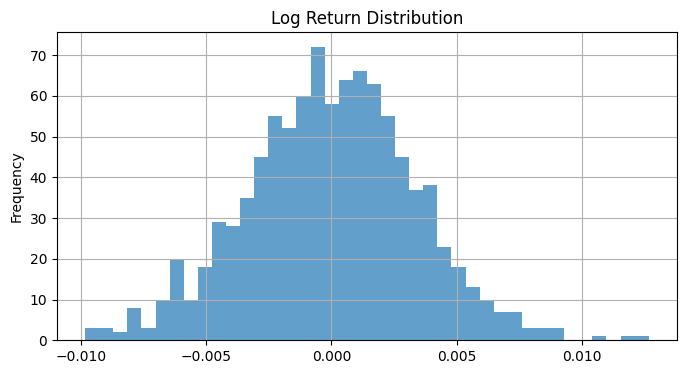

In [3]:
feature_frame['log_return'].plot.hist(bins=40, alpha=0.7)
plt.title('Log Return Distribution')


In [4]:
data_cfg = DataConfig(
    source='synthetic',
    features=[
        'log_return',
        'hl_spread',
        'hl_range_pct',
        'close_location',
        'volume_change',
        'rolling_volatility',
    ],
    target='close_return',
    lookback=32,
    horizon=8,
    batch_size=32,
    include_future_features=True,
    val_fraction=0.1,
    test_fraction=0.1,
)
builder = DataModuleBuilder(data_cfg)
datamodule = builder.build_datamodule(feature_frame)
datamodule.setup('fit')

Text(0.5, 1.0, 'Rolling Volatility Distribution')

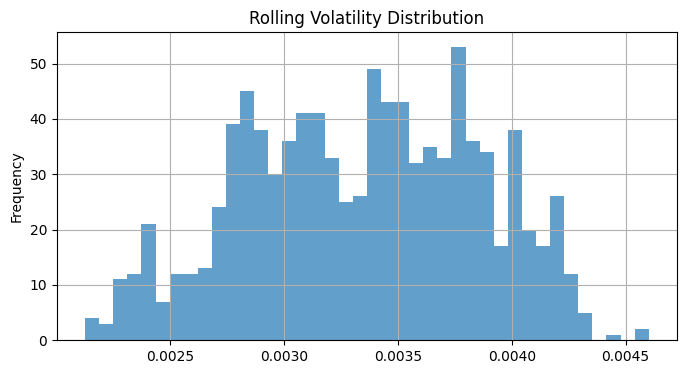

In [5]:
feature_frame['rolling_volatility'].plot.hist(bins=40, alpha=0.7)
plt.title('Rolling Volatility Distribution')


## PatchTST Reference Run

In [6]:
patch_config = PatchTSTReferenceConfig(
    input_dim=len(data_cfg.features),
    patch_length=8,
    stride=4,
    d_model=128,
    nheads=8,
    depth=4,
    dropout=0.2,
)
patch_model = PatchTSTReference(patch_config)
patch_module = ForecastingModule(
    backbone=patch_model,
    horizon=data_cfg.horizon,
    optimizer_params=OptimizerParams(lr=3e-4, weight_decay=1e-4),
)
trainer_patch = pl.Trainer(
    max_epochs=5,
    accelerator='cpu',
    gradient_clip_val=1.0,
    enable_checkpointing=False,
    logger=False,
)
trainer_patch.fit(patch_module, datamodule=datamodule)

/Users/mohamedali/trading_project/models/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mohamedali/trading_project/models/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | backbone | PatchTSTReference | 799 K  | train
1 | head     | Linear            | 1.0 K  | train
-------------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.203     Total estimated model params size (MB)
49        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/mohamedali/trading_project/models/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/mohamedali/trading_project/models/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## Temporal Fusion Transformer Run

In [7]:
tft_config = TemporalFusionTransformerConfig(
    input_dim=len(data_cfg.features),
    d_model=128,
    nheads=4,
    depth=2,
    dropout=0.1,
)
tft_model = TemporalFusionTransformerBackbone(tft_config)
tft_module = ForecastingModule(
    backbone=tft_model,
    horizon=data_cfg.horizon,
    optimizer_params=OptimizerParams(lr=3e-4, weight_decay=1e-4),
)
trainer_tft = pl.Trainer(
    max_epochs=5,
    accelerator='cpu',
    gradient_clip_val=1.0,
    enable_checkpointing=False,
    logger=False,
)
trainer_tft.fit(tft_module, datamodule=datamodule)

/Users/mohamedali/trading_project/models/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mohamedali/trading_project/models/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name     | Type                              | Params | Mode 
-----------------------------------------------------------------------
0 | backbone | TemporalFusionTransformerBackbone | 927 K  | train
1 | head     | Linear                            | 1.0 K  | train
-----------------------------------------------------------------------
928 K     Trainable params
0         Non-trainable params
928 K     Total params
3.715     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/mohamedali/trading_project/models/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/mohamedali/trading_project/models/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


### Quick Metric Peek

In [8]:
patch_metrics = trainer_patch.callback_metrics
tft_metrics = trainer_tft.callback_metrics

summary = pd.DataFrame(
    {
        'patchtst_reference': {k: float(v.cpu()) for k, v in patch_metrics.items()},
        'temporal_fusion_transformer': {k: float(v.cpu()) for k, v in tft_metrics.items()},
    }
)
summary.round(4)

,patchtst_reference,temporal_fusion_transformer
train_loss,0.0951,0.0865
train_mae,0.2576,0.2131
val_loss,0.1202,0.1167
val_mae,0.2749,0.2691
val_rmse,0.3467,0.3416
val_mape,1.5580,1.2293
val_bias,0.0052,0.0309
val_std_ratio,0.2515,0.1309
val_directional_acc,0.4960,0.4543
val_hit_rate,0.4960,0.4543
